![](./noice.jpg "noice")

# Reduction Approach

In [2]:
import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

from utils import *

path = './summer_2022_project/'
audio_path = path + 'audio/'

df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
eval_df = pd.read_csv(path+'evaluation.csv', dtype={'filename':'string'}) # set string as type

labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels

df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

/Users/lorenzo/opt/anaconda3/envs/data_science/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


In [15]:
df.loc[8005]

emotion                 Sad
filename           8005.wav
encoded_emotion           5
Name: 8005, dtype: object

In [21]:
%%capture
d = dict()
# all the files have been sampled using the same sample rate. Hence we extract it
sr, _ = wavfile.read(audio_path + df.filename.iloc[0])
for filename in tqdm(df.filename):
    d1 = dict()
    features = []
    signal, _ = librosa.load(audio_path+filename, sr=None, res_type='kaiser_fast')
    try:
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs, axis=-1) #mean along time axis. 1 value for each coefficient, the mean one
        mfccs_std = np.std(mfccs, axis=-1) #std along time axis. 1 value for each coefficient, the std one
        res = np.hstack((mfccs_mean, mfccs_std))
        delta_mfccs_mean = np.mean(librosa.feature.delta(mfccs), axis=-1)
        res = np.hstack((res, delta_mfccs_mean))
        delta2_mfccs_mean = np.mean(librosa.feature.delta(mfccs, order=2), axis=-1)
        res = np.hstack((res, delta2_mfccs_mean))
        #mel_mean = np.mean(librosa.feature.melspectrogram(signal, sr), axis=-1)
        #mel_std = np.std(librosa.feature.melspectrogram(signal, sr), axis=-1)
        stft = np.abs(librosa.stft(signal))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=-1)
        res = np.hstack((res, chroma_stft))
        
        
        
        d1 = {f'feature_{k}':v for k,v in enumerate(res)} # extract mfccs
        
        d1['duration'] = signal.shape[0]/sr
        d1['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
        #d1['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
        d1['rms'] = np.mean(librosa.feature.rms(y=signal), axis=-1)[0]
    except:
        print(filename)
        continue
    d[(int)(filename.split('.')[0])] = d1
    
temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()

In [6]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9596 entries, 0 to 9596
Data columns (total 96 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   feature_0        9596 non-null   float64
 1   feature_1        9596 non-null   float64
 2   feature_2        9596 non-null   float64
 3   feature_3        9596 non-null   float64
 4   feature_4        9596 non-null   float64
 5   feature_5        9596 non-null   float64
 6   feature_6        9596 non-null   float64
 7   feature_7        9596 non-null   float64
 8   feature_8        9596 non-null   float64
 9   feature_9        9596 non-null   float64
 10  feature_10       9596 non-null   float64
 11  feature_11       9596 non-null   float64
 12  feature_12       9596 non-null   float64
 13  feature_13       9596 non-null   float64
 14  feature_14       9596 non-null   float64
 15  feature_15       9596 non-null   float64
 16  feature_16       9596 non-null   float64
 17  feature_17    

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


scores_rf = []
scores_svm = []

np.random.seed(0) #to make experiments reproducible


smote = SMOTE(random_state=42)

X, y = temp_df[temp_df.columns[:-1]], temp_df[temp_df.columns[-1]]
X_res, y_res = smote.fit_resample(X,y)

# ----- PCA ----- #
from sklearn.decomposition import PCA

n=50
pca = PCA(n_components=n)
X_res = pca.fit_transform(X_res)
# ----- PCA ----- #

minmax = MinMaxScaler()
svm_X_res = minmax.fit_transform(X_res)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('Fitting RF...')
rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
print('Predicting using RF...')
preds = rf.predict(X_test)
score = f1_score(y_test, preds, average='macro')
scores_rf.append(score)
print(rf, score)

print('Fitting SVC...')
svm = SVC().fit(svm_X_train, y_train)
print('Predicting using SVC...')
svm_preds = svm.predict(svm_X_test)
svm_score = f1_score(y_test, svm_preds, average='macro')
scores_svm.append(svm_score)
print(svm, svm_score)



Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6984523023285376
Fitting SVC...
Predicting using SVC...
SVC() 0.720459349973933


<AxesSubplot:>

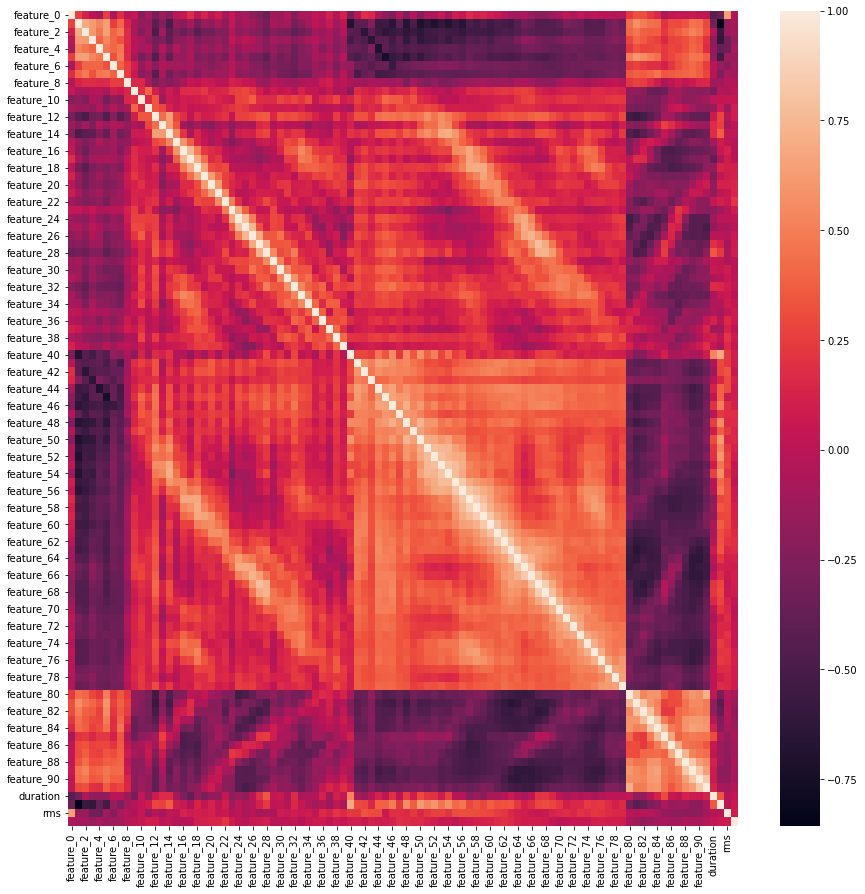

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(temp_df.corr())

  0%|          | 0/31 [00:00<?, ?it/s]

20
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6913805361355426
Fitting SVC...
Predicting using SVC...


  3%|▎         | 1/31 [00:06<03:27,  6.90s/it]

SVC() 0.6747630775988489
25
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6972626387658091
Fitting SVC...
Predicting using SVC...


  6%|▋         | 2/31 [00:15<03:42,  7.67s/it]

SVC() 0.6959274388339969
30
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6978762406830743
Fitting SVC...
Predicting using SVC...


 10%|▉         | 3/31 [00:23<03:42,  7.94s/it]

SVC() 0.6955496460757157
35
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6980786403059762
Fitting SVC...
Predicting using SVC...


 13%|█▎        | 4/31 [00:32<03:41,  8.22s/it]

SVC() 0.7034155346393983
40
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6960381009262411
Fitting SVC...
Predicting using SVC...


 16%|█▌        | 5/31 [00:41<03:46,  8.73s/it]

SVC() 0.715888156072168
45
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7038638707135908
Fitting SVC...
Predicting using SVC...


 19%|█▉        | 6/31 [00:51<03:50,  9.23s/it]

SVC() 0.7171724301236025
50
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.710683491445156
Fitting SVC...
Predicting using SVC...


 23%|██▎       | 7/31 [01:02<03:52,  9.69s/it]

SVC() 0.7189440653706256
55
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7001268073901432
Fitting SVC...
Predicting using SVC...


 26%|██▌       | 8/31 [01:13<03:52, 10.09s/it]

SVC() 0.7283334823799157
60
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6938169894292746
Fitting SVC...
Predicting using SVC...


 29%|██▉       | 9/31 [01:24<03:51, 10.54s/it]

SVC() 0.7222166041454788
65
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7041122186419164
Fitting SVC...
Predicting using SVC...


 32%|███▏      | 10/31 [01:36<03:48, 10.89s/it]

SVC() 0.7240059399146495
70
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6842992532129359
Fitting SVC...
Predicting using SVC...


 35%|███▌      | 11/31 [01:49<03:47, 11.35s/it]

SVC() 0.7239566019944198
75
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6961455647672395
Fitting SVC...
Predicting using SVC...


 39%|███▊      | 12/31 [02:02<03:45, 11.85s/it]

SVC() 0.716355947166237
80
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6955807457758202
Fitting SVC...
Predicting using SVC...


 42%|████▏     | 13/31 [02:14<03:39, 12.19s/it]

SVC() 0.7237033222707453
85
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.685325381467125
Fitting SVC...
Predicting using SVC...


 45%|████▌     | 14/31 [02:28<03:35, 12.66s/it]

SVC() 0.7192949042089751
90
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.702385705545454
Fitting SVC...
Predicting using SVC...


 48%|████▊     | 15/31 [02:42<03:28, 13.05s/it]

SVC() 0.7268420592797187
95
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6957648406023804
Fitting SVC...
Predicting using SVC...


 52%|█████▏    | 16/31 [02:57<03:22, 13.47s/it]

SVC() 0.7265020462796067
100
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.690794664230503
Fitting SVC...
Predicting using SVC...


 55%|█████▍    | 17/31 [03:11<03:12, 13.75s/it]

SVC() 0.723794945037198
105
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6956750118194863
Fitting SVC...
Predicting using SVC...


 58%|█████▊    | 18/31 [03:26<03:04, 14.16s/it]

SVC() 0.7223970274159447
110
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6935754753059147
Fitting SVC...
Predicting using SVC...


 61%|██████▏   | 19/31 [03:42<02:54, 14.57s/it]

SVC() 0.7202408426919751
115
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6829614034397314
Fitting SVC...
Predicting using SVC...


 65%|██████▍   | 20/31 [03:57<02:42, 14.77s/it]

SVC() 0.717472107966901
120
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.690985779769225
Fitting SVC...
Predicting using SVC...


 68%|██████▊   | 21/31 [04:13<02:30, 15.09s/it]

SVC() 0.7190095282839536
125
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6911452055025805
Fitting SVC...
Predicting using SVC...


 71%|███████   | 22/31 [04:30<02:20, 15.59s/it]

SVC() 0.7204225541596747
130
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6945732226082445
Fitting SVC...
Predicting using SVC...


 74%|███████▍  | 23/31 [04:45<02:03, 15.49s/it]

SVC() 0.7175705160384848
135
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6920264100780159
Fitting SVC...
Predicting using SVC...


 77%|███████▋  | 24/31 [05:01<01:50, 15.72s/it]

SVC() 0.7200209391800063
140
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6861317525904914
Fitting SVC...
Predicting using SVC...


 81%|████████  | 25/31 [05:17<01:34, 15.81s/it]

SVC() 0.7134323721379611
145
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6765088977084744
Fitting SVC...
Predicting using SVC...


 84%|████████▍ | 26/31 [05:34<01:20, 16.01s/it]

SVC() 0.7117112404769268
150
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.686724100346324
Fitting SVC...
Predicting using SVC...


 87%|████████▋ | 27/31 [05:50<01:04, 16.18s/it]

SVC() 0.7103988578119668
155
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6895404083632155
Fitting SVC...
Predicting using SVC...


 90%|█████████ | 28/31 [06:07<00:49, 16.49s/it]

SVC() 0.7116704809785636
160
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.678222616285489
Fitting SVC...
Predicting using SVC...


 94%|█████████▎| 29/31 [06:24<00:33, 16.50s/it]

SVC() 0.7099988027005123
165
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6797225766914764
Fitting SVC...
Predicting using SVC...


 97%|█████████▋| 30/31 [06:41<00:16, 16.76s/it]

SVC() 0.709734178155949
170
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6938271469010732
Fitting SVC...
Predicting using SVC...


100%|██████████| 31/31 [07:00<00:00, 13.55s/it]

SVC() 0.7065761634126043


Text(0.5, 1.0, 'F1 macro score as number of PCA components varies')

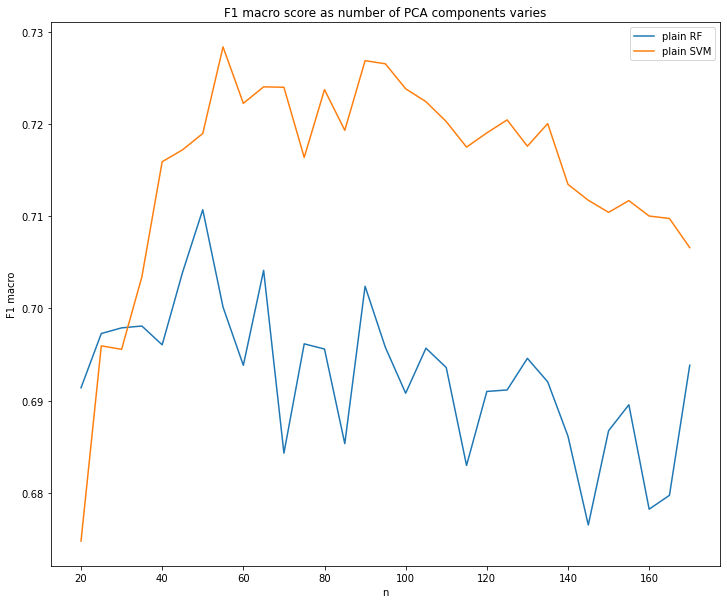

In [23]:
# PCA tuning

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


scores_rf = []
scores_svm = []

np.random.seed(0) #to make experiments reproducible


smote = SMOTE(random_state=42)

X, y = temp_df[temp_df.columns[:-1]], temp_df[temp_df.columns[-1]]
X_res, y_res = smote.fit_resample(X,y)

# ----- PCA ----- #
from sklearn.decomposition import PCA

ns = list(range(20, len(X.columns),5))
for n in tqdm(ns):
    print(n)
    pca = PCA(n_components=n, random_state=42)
    pca_X_res = pca.fit_transform(X_res)


    minmax = MinMaxScaler()
    svm_X_res = minmax.fit_transform(pca_X_res)

    X_train, X_test, y_train, y_test = train_test_split(pca_X_res, y_res, test_size=.2, random_state=42)
    svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    print('Fitting RF...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting using RF...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores_rf.append(score)
    print(rf, score)

    print('Fitting SVC...')
    svm = SVC().fit(svm_X_train, y_train)
    print('Predicting using SVC...')
    svm_preds = svm.predict(svm_X_test)
    svm_score = f1_score(y_test, svm_preds, average='macro')
    scores_svm.append(svm_score)
    print(svm, svm_score)

# ----- PCA ----- #
plt.figure(figsize=(12,10))
plt.plot(ns, scores_rf, label='plain RF')
plt.plot(ns, scores_svm, label='plain SVM')
plt.legend()
plt.xlabel('n')
plt.ylabel('F1 macro')
plt.title('F1 macro score as number of PCA components varies')

In [25]:
best_id = np.argmax(scores_svm)
best_n = ns[best_id]
best_n
scores_svm[best_id]

0.7283334823799157

In [39]:
best_n

55

In [35]:
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, ParameterGrid
best_id = np.argmax(scores_svm)
best_n = ns[best_id]
pca = PCA(n_components=best_n, random_state=42)
pca_X_res = pca.fit_transform(X_res)


minmax = MinMaxScaler()
svm_X_res = minmax.fit_transform(pca_X_res)

svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

param_grid = {'C':[1,2, 3,4, 5,6, 7,8,9, 10, 15, 20, 30, 50],}
              #'kernel': ['rbf', 'linear', 'sigmoid']}
              

clfs = []
for configuration in tqdm(ParameterGrid(param_grid)):
    print('Fitting SVC...')
    svm = SVC(random_state=42, **configuration).fit(svm_X_train, y_train)
    print('Predicting using SVC...')
    svm_preds = svm.predict(svm_X_test)
    svm_score = f1_score(y_test, svm_preds, average='macro')
    print(svm, svm_score)
    clfs.append((svm, svm_score))
#---tutti peggiori---#
# print('Fitting NuSVC...')
# svm = NuSVC(random_state=42).fit(svm_X_train, y_train)
# print('Predicting using NuSVC...')
# svm_preds = svm.predict(svm_X_test)
# svm_score = f1_score(y_test, svm_preds, average='macro')
# print(svm, svm_score)
# print('Fitting LinearSVC...')
# svm = LinearSVC(random_state=42).fit(svm_X_train, y_train)
# print('Predicting using LinearSVC...')
# svm_preds = svm.predict(svm_X_test)
# svm_score = f1_score(y_test, svm_preds, average='macro')
# print(svm, svm_score)

  0%|          | 0/14 [00:00<?, ?it/s]

Fitting SVC...
Predicting using SVC...


  7%|▋         | 1/14 [00:06<01:21,  6.25s/it]

SVC(C=1, random_state=42) 0.7283334823799157
Fitting SVC...
Predicting using SVC...


 14%|█▍        | 2/14 [00:12<01:15,  6.33s/it]

SVC(C=2, random_state=42) 0.7369503271186743
Fitting SVC...
Predicting using SVC...


 21%|██▏       | 3/14 [00:18<01:09,  6.31s/it]

SVC(C=3, random_state=42) 0.7472682754399623
Fitting SVC...
Predicting using SVC...


 29%|██▊       | 4/14 [00:25<01:02,  6.29s/it]

SVC(C=4, random_state=42) 0.7449579679508097
Fitting SVC...
Predicting using SVC...


 36%|███▌      | 5/14 [00:31<00:55,  6.21s/it]

SVC(C=5, random_state=42) 0.7429204301939057
Fitting SVC...
Predicting using SVC...


 43%|████▎     | 6/14 [00:37<00:49,  6.20s/it]

SVC(C=6, random_state=42) 0.7440971016588501
Fitting SVC...
Predicting using SVC...


 50%|█████     | 7/14 [00:43<00:43,  6.20s/it]

SVC(C=7, random_state=42) 0.7453023236726072
Fitting SVC...
Predicting using SVC...


 57%|█████▋    | 8/14 [00:50<00:37,  6.31s/it]

SVC(C=8, random_state=42) 0.7423225492670861
Fitting SVC...
Predicting using SVC...


 64%|██████▍   | 9/14 [00:56<00:31,  6.32s/it]

SVC(C=9, random_state=42) 0.7419390578680428
Fitting SVC...
Predicting using SVC...


 71%|███████▏  | 10/14 [01:02<00:25,  6.33s/it]

SVC(C=10, random_state=42) 0.7393284437819517
Fitting SVC...
Predicting using SVC...


 79%|███████▊  | 11/14 [01:09<00:19,  6.40s/it]

SVC(C=15, random_state=42) 0.7393885181239837
Fitting SVC...
Predicting using SVC...


 86%|████████▌ | 12/14 [01:16<00:13,  6.50s/it]

SVC(C=20, random_state=42) 0.7420771829891667
Fitting SVC...
Predicting using SVC...


 93%|█████████▎| 13/14 [01:23<00:06,  6.63s/it]

SVC(C=30, random_state=42) 0.7366641435761131
Fitting SVC...
Predicting using SVC...


100%|██████████| 14/14 [01:30<00:00,  6.43s/it]

SVC(C=50, random_state=42) 0.7354372804390924


In [46]:
clfs[np.argmax([clf[1] for clf in clfs])]

(SVC(C=3, random_state=42), 0.7472682754399623)

In [40]:
pca

PCA(n_components=55, random_state=42)

In [42]:
# eval

d = dict()
for filename in tqdm(eval_df.filename):
    d1 = dict()
    features = []
    signal, _ = librosa.load(audio_path+filename, sr=None, res_type='kaiser_fast')
    try:
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs, axis=-1) #mean along time axis. 1 value for each coefficient, the mean one
        mfccs_std = np.std(mfccs, axis=-1) #std along time axis. 1 value for each coefficient, the std one
        res = np.hstack((mfccs_mean, mfccs_std))
        delta_mfccs_mean = np.mean(librosa.feature.delta(mfccs), axis=-1)
        res = np.hstack((res, delta_mfccs_mean))
        delta2_mfccs_mean = np.mean(librosa.feature.delta(mfccs, order=2), axis=-1)
        res = np.hstack((res, delta2_mfccs_mean))
        #mel_mean = np.mean(librosa.feature.melspectrogram(signal, sr), axis=-1)
        #mel_std = np.std(librosa.feature.melspectrogram(signal, sr), axis=-1)
        stft = np.abs(librosa.stft(signal))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=-1)
        res = np.hstack((res, chroma_stft))
        
        
        
        d1 = {f'feature_{k}':v for k,v in enumerate(res)} # extract mfccs
        
        d1['duration'] = signal.shape[0]/sr
        d1['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
        #d1['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
        d1['rms'] = np.mean(librosa.feature.rms(y=signal), axis=-1)[0]
    except:
        print(filename)
        continue
    d[(int)(filename.split('.')[0])] = d1
    
eval_temp_df = pd.DataFrame.from_dict(d).T    

#temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
eval_temp_df = eval_temp_df.astype({'duration':float})
eval_temp_df.head()
indexes = eval_temp_df.index

100%|██████████| 3201/3201 [00:58<00:00, 54.82it/s]


In [52]:
prova = pca.transform(eval_temp_df)
prova = minmax.transform(prova)

pd.DataFrame(prova)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.249479,0.460955,0.488623,0.285264,0.475523,0.640129,0.532603,0.425557,0.277063,0.472352,...,0.558911,0.415129,0.557953,0.446390,0.377057,0.404590,0.285816,0.378112,0.528744,0.467928
1,0.224750,0.445040,0.239426,0.359362,0.441737,0.554971,0.281784,0.648945,0.360532,0.678501,...,0.457287,0.363020,0.260013,0.289263,0.498363,0.614584,0.368950,0.353893,0.479776,0.332455
2,0.414452,0.531337,0.591890,0.230686,0.611225,0.597634,0.432847,0.660534,0.185966,0.499201,...,0.408280,0.484735,0.499421,0.418747,0.496031,0.614164,0.318619,0.514875,0.613224,0.609297
3,0.412585,0.219967,0.224099,0.334351,0.319365,0.423864,0.310607,0.519312,0.506525,0.676614,...,0.541068,0.405020,0.641023,0.426544,0.254058,0.487025,0.505474,0.522390,0.519739,0.432498
4,0.267336,0.617134,0.365043,0.326685,0.331832,0.354969,0.295488,0.482385,0.364117,0.542957,...,0.552975,0.343814,0.432956,0.392339,0.402297,0.437887,0.406097,0.402890,0.435145,0.465370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,0.474386,0.258731,0.229866,0.405492,0.372265,0.473691,0.405849,0.362569,0.471129,0.396225,...,0.424602,0.362469,0.457027,0.313222,0.458932,0.647072,0.336877,0.364248,0.461353,0.337028
3197,0.202627,0.437944,0.279579,0.342552,0.445071,0.510615,0.612660,0.284738,0.440163,0.312498,...,0.577923,0.304729,0.469689,0.269570,0.380259,0.407570,0.480612,0.411692,0.520769,0.325716
3198,0.439883,0.277922,0.316728,0.374890,0.682962,0.458456,0.320537,0.740732,0.261928,0.265256,...,0.397650,0.304433,0.327721,0.405210,0.475768,0.513065,0.421628,0.373251,0.521701,0.462032
3199,0.305365,0.527842,0.505844,0.367403,0.574721,0.594971,0.542889,0.307699,0.342302,0.371915,...,0.490763,0.577086,0.279401,0.272949,0.512525,0.479126,0.361502,0.528063,0.468140,0.406248


In [51]:
f1_score(y_test, clfs[np.argmax([clf[1] for clf in clfs])][0].predict(svm_X_test), average='macro')

0.7472682754399623

In [53]:
svm_clf = clfs[np.argmax([clf[1] for clf in clfs])][0]
preds = svm_clf.predict(prova)
preds 

array([5, 3, 5, ..., 5, 5, 3])

In [54]:
lista_finale = []
preds_ser = pd.Series(preds)
for id, label in zip(eval_temp_df.index, preds_ser.map({v:k for k,v in labels_dict.items()})):
    lista_finale.append((f'{id}.wav', label))
df_finale = pd.DataFrame(lista_finale, columns=['Id', 'Predicted'])
df_finale.to_csv(path_or_buf=path+'/results/svm_pca.csv', header=True, index=False)

In [55]:
preds

array([5, 3, 5, ..., 5, 5, 3])

In [14]:
import lightgbm as lgb
clf = lgb.LGBMClassifier().fit(X_train, y_train)

array([5, 6, 3, ..., 5, 1, 4])